In [117]:
%load_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd
import seaborn as sn
import json
import glob, os
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.patches import Ellipse
import matplotlib.transforms as transforms
from mpl_toolkits.mplot3d import Axes3D
from scipy import stats
from numpy.random import seed
from scipy.stats import kruskal
from scipy.stats import levene

from termcolor import colored
import my_plots

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [79]:
# plot settings

lw = 1.5

fs = 13

params = {
    'axes.labelsize': fs,
    'font.size': fs,
    'legend.fontsize': fs,
    'xtick.labelsize': fs,
    'ytick.labelsize': fs,
    'text.usetex': False,
    'figure.figsize': [6, 6],
    'boxplot.boxprops.linewidth' : lw,
    'boxplot.whiskerprops.linewidth' : lw,
    'boxplot.capprops.linewidth' : lw,
    'boxplot.medianprops.linewidth' : lw,
    'text.usetex' : True,
    'font.family' : 'serif',

   }
mpl.rcParams.update(params)

In [4]:
def dfFromJSON(file):
    with open(file) as f:
        temp = []
        for line in f:
            temp.append(json.loads(line))
            
    df = pd.io.json.json_normalize(temp[0]['allLogs'])
    df.columns = df.columns.map(lambda x: x.split("*.")[-1])
    return df

In [5]:
def appendToLogs(file, log, _type):
    df = dfFromJSON(file)
    log[_type].append(df)

In [6]:
path_to_folder = "/Volumes/GoogleDrive/My Drive/Matteo/EPFL/LIS/PhD/Bidirectional_wearable_interface/DATA/Haptics/Haptics_Z/"
subjects = glob.glob(path_to_folder + "*/")

logs = {}
for curr in subjects:
    logs[curr] = []
    
subjects.sort()

['/Volumes/GoogleDrive/My Drive/Matteo/EPFL/LIS/PhD/Bidirectional_wearable_interface/DATA/Haptics/Haptics_Z/sub10_Controller/',
 '/Volumes/GoogleDrive/My Drive/Matteo/EPFL/LIS/PhD/Bidirectional_wearable_interface/DATA/Haptics/Haptics_Z/sub10_MotionCapture/',
 '/Volumes/GoogleDrive/My Drive/Matteo/EPFL/LIS/PhD/Bidirectional_wearable_interface/DATA/Haptics/Haptics_Z/sub2_Controller/',
 '/Volumes/GoogleDrive/My Drive/Matteo/EPFL/LIS/PhD/Bidirectional_wearable_interface/DATA/Haptics/Haptics_Z/sub2_MotionCapture/',
 '/Volumes/GoogleDrive/My Drive/Matteo/EPFL/LIS/PhD/Bidirectional_wearable_interface/DATA/Haptics/Haptics_Z/sub3_Controller/',
 '/Volumes/GoogleDrive/My Drive/Matteo/EPFL/LIS/PhD/Bidirectional_wearable_interface/DATA/Haptics/Haptics_Z/sub3_MotionCapture/',
 '/Volumes/GoogleDrive/My Drive/Matteo/EPFL/LIS/PhD/Bidirectional_wearable_interface/DATA/Haptics/Haptics_Z/sub4_Controller/',
 '/Volumes/GoogleDrive/My Drive/Matteo/EPFL/LIS/PhD/Bidirectional_wearable_interface/DATA/Haptics/Ha

## Remove outliers

In [7]:
# # used to remove outliers

# subjects.remove(subjects[5])
# subjects.remove(subjects[4])

# logs = {}
# for curr in subjects:
#     logs[curr] = []
    
# subjects

# Import data

In [8]:
EXP_N_THOMAS = 4
EXP_N = 5

for subject in subjects:
#     print(subject)
    files = glob.glob(subject+"*.json")
    files.sort()
    
    if len(files) != EXP_N and len(files) != EXP_N_THOMAS:
        print(subject)
        print('wrong number of experiments!')
        break
    for file in files:
        print('.')
        logs[subject].append(dfFromJSON(file))

/Volumes/GoogleDrive/My Drive/Matteo/EPFL/LIS/PhD/Bidirectional_wearable_interface/DATA/Haptics/Haptics_Z/sub10_Controller/
/Volumes/GoogleDrive/My Drive/Matteo/EPFL/LIS/PhD/Bidirectional_wearable_interface/DATA/Haptics/Haptics_Z/sub10_Controller/Haptics_GoThroughZ_2019_08_28_15_12_32.json
/Volumes/GoogleDrive/My Drive/Matteo/EPFL/LIS/PhD/Bidirectional_wearable_interface/DATA/Haptics/Haptics_Z/sub10_Controller/Haptics_GoThroughZ_2019_08_28_15_12_47.json
/Volumes/GoogleDrive/My Drive/Matteo/EPFL/LIS/PhD/Bidirectional_wearable_interface/DATA/Haptics/Haptics_Z/sub10_Controller/Haptics_GoThroughZ_2019_08_28_15_13_17.json
/Volumes/GoogleDrive/My Drive/Matteo/EPFL/LIS/PhD/Bidirectional_wearable_interface/DATA/Haptics/Haptics_Z/sub10_Controller/Haptics_GoThroughZ_2019_08_28_15_13_29.json
/Volumes/GoogleDrive/My Drive/Matteo/EPFL/LIS/PhD/Bidirectional_wearable_interface/DATA/Haptics/Haptics_Z/sub10_Controller/Haptics_GoThroughZ_2019_08_28_15_13_53.json
/Volumes/GoogleDrive/My Drive/Matteo/EPFL

In [9]:
fields = ['first motion', 'last motion', 'first remote', 'last remote']
interfaces = ['motion', 'remote']

sub_remote = [x for x in subjects if 'Controller' in x]
sub_motion = [x for x in subjects if 'Motion' in x]

t = [logs[x] for x in sub_motion]
logs['motion'] = []
for i in t:
    for j in i:
        logs['motion'].append(j)

t = [logs[x] for x in sub_remote]
logs['remote'] = []
for i in t:
    for j in i:
        logs['remote'].append(j)

logs['first motion'] = [logs[x][0] for x in sub_motion]
logs['last motion'] = [logs[x][-1] for x in sub_motion]
logs['first remote'] = [logs[x][0] for x in sub_remote]
logs['last remote'] = [logs[x][-1] for x in sub_remote]

# Analysis scripts

In [72]:
def t_test_kruskal(X, Y):
    
    # Kruskal-Wallis H-test
    
    # seed the random number generator
    seed(1)
    
    # compare samples
    stat, p = kruskal(X, Y)
    
    return [stat, p]

def t_test_levene(X, Y):
    
    # Kruskal-Wallis H-test
    
    # seed the random number generator
    seed(1)
    
    # compare samples
    stat, p = levene(X, Y)
    
    return [stat, p]

def str_from_p(p):
    
    if p<0.01:
        add_str = ' !!!!!!!!!!'
    elif p<0.05:
        add_str = ' !!!!!!'
    elif p<0.1:
        add_str = ' !'
    else:
        add_str = ''
        
    return add_str

def print_p(p):
    
    col = None
    
    if p<0.01:
        col = 'green'
    elif p<0.05:
        col = 'yellow'
    elif p<0.1:
        col = 'red'
        
    if col is not None:
        print(colored('p = '+ str(p) + str_from_p(p), col))
    else:
        print('p = '+ str(p) + str_from_p(p))

def runBasicAnalysis(f):
    
    var = {}

    var['means'] = []
    var['stds'] = []

    for i in fields:
        var[i] = []
        for j in logs[i]:
            var[i].append(f(j))
        print(i)
        print(var[i])

        var['means'].append(np.mean(var[i]))
        var['stds'].append(np.std(var[i]))

        print('mean = ', var['means'][-1])
        print('std = ', var['stds'][-1])

        print()
        
            
    for idx,i in enumerate(fields):
        for j in fields[idx+1:]:
            if i != j:
                
                t, p = t_test_kruskal(var[i],var[j])
                
                print (i,j)
                print_p(p)
            
    var['diff mot'] = 1-np.array(var['last motion'])/np.array(var['first motion'])
    var['diff rem'] = 1-np.array(var['last remote'])/np.array(var['first remote'])

    print()
    print('motion ratio')
    print(var['diff mot'])
    print(np.mean(var['diff mot']))
    print(np.std(var['diff mot']))
    print()
    print('remote ratio')
    print(var['diff rem'])
    print(np.mean(var['diff rem']))
    print(np.std(var['diff rem']))

    t, p = t_test_kruskal(var['diff mot'], var['diff rem'])

    print()
    print('p = ', p, str_from_p(p))
            
    var['diff first'] = 1-np.array(var['first motion'])/np.array(var['first remote'])
    var['diff last'] = 1-np.array(var['last motion'])/np.array(var['last remote'])

    print()
    print('firts ratio')
    print(var['diff first'])
    print(np.mean(var['diff first']))
    print(np.std(var['diff first']))
    print()
    print('last ratio')
    print(var['diff last'])
    print(np.mean(var['diff last']))
    print(np.std(var['diff last']))

    t, p = t_test_kruskal(var['diff first'], var['diff last'])

    print()
    print('p = ', p, str_from_p(p))
            
    return var

def runHapticsXAnalysis(f):
    
    var = {}

    var['means'] = []
    var['stds'] = []

    for i in interfaces:
        var[i] = []
        for j in logs[i]:
            var[i].append(f(j))
        print(i)
        print(var[i])

        var['means'].append(np.mean(var[i]))
        var['stds'].append(np.std(var[i]))

        print('mean = ', var['means'][-1])
        print('std = ', var['stds'][-1])

        print()
        
            
    for idx,i in enumerate(interfaces):
        for j in interfaces[idx+1:]:
            if i != j:
                
                t, p = t_test_kruskal(var[i],var[j])
                print_p(p)
                
    return var

def runHapticsZAnalysis(f):
    
    varX = {}
    varY = {}

    varX['means'] = []
    varX['stds'] = []
    varY['means'] = []
    varY['stds'] = []

    for i in interfaces:
        varX[i] = []
        varY[i] = []
        for j in logs[i]:
            varX[i].append(f(j)[0])
            varY[i].append(f(j)[1])
        print(i)
        print(varX[i])
        print(varY[i])

        varX['means'].append(np.mean(varX[i]))
        varX['stds'].append(np.std(varX[i]))
        varY['means'].append(np.mean(varY[i]))
        varY['stds'].append(np.std(varY[i]))

        print('mean = ', varX['means'][-1])
        print('std = ', varX['stds'][-1])
        print('mean = ', varY['means'][-1])
        print('std = ', varY['stds'][-1])

        print()
        
            
    for idx,i in enumerate(interfaces):
        for j in interfaces[idx+1:]:
            if i != j:
                
                tX, pX = t_test_kruskal(varX[i],varX[j])
                tY, pY = t_test_kruskal(varY[i],varY[j])
                
                print('')
                print(i,j, ' X')
                print_p(pX)
                print('')
                print(i,j, ' Y')
                print_p(pY)
                
    return [varX, varY]

def basic_plot(var):
    
    fig = plt.figure(figsize=(12, 4))
    ax = fig.add_subplot(131)
    ax.bar([0, 1, 2, 3],
       var['means'],
       yerr=var['stds'])

    plt.xticks(range(4), fields, rotation = 10)

    ax = fig.add_subplot(132)
    ax.bar([0, 1],
       [np.mean(var['diff mot']), np.mean(var['diff rem'])],
       yerr=[np.std(var['diff mot']), np.std(var['diff rem'])])
    
    plt.xticks(range(2), ['motion', 'remote'], rotation = 10)

    ax = fig.add_subplot(133)
    ax.bar([0, 1],
       [np.mean(var['diff first']), np.mean(var['diff last'])],
       yerr=[np.std(var['diff first']), np.std(var['diff last'])])
    
    plt.xticks(range(2), ['first', 'last'], rotation = 10)

In [13]:
def moving_average(data_set, periods=3, fill_with_zeros = True):
    
    if data_set.size < periods:
        return data_set
    
    if isinstance(data_set, pd.DataFrame):
        print('a')
        data_set.index = range(len(data_set))

    weights = np.ones(periods) / periods
    
    ma = np.convolve(data_set, weights, mode='valid')

    if fill_with_zeros:
        fill_before = np.ones(int(np.ceil((len(data_set) - len(ma))/2))) * data_set[0]
        fill_after = np.ones(int(np.floor((len(data_set) - len(ma))/2))) * data_set[-1]
        ma = np.hstack([fill_before, ma, fill_after])
    
    return ma

def filter_position(df, steps):
    
    l = moving_average(df['dronePosition.x'], periods=steps, fill_with_zeros = False)
    df['dronePositionFiltered.x'] = np.append([l[0]]*(steps-1), l)
    l = moving_average(df['dronePosition.y'], periods=steps, fill_with_zeros = False)
    df['dronePositionFiltered.y'] = np.append([l[0]]*(steps-1), l)
    l = moving_average(df['dronePosition.x'], periods=steps, fill_with_zeros = False)
    df['dronePositionFiltered.x'] = np.append([l[0]]*(steps-1), l)
    return df

def running_average(signal, steps):
    
    l = moving_average(signal, periods=steps, fill_with_zeros = False)
    out = np.append([l[0]]*(steps-1), l)
    return out

# Plot Trajectories

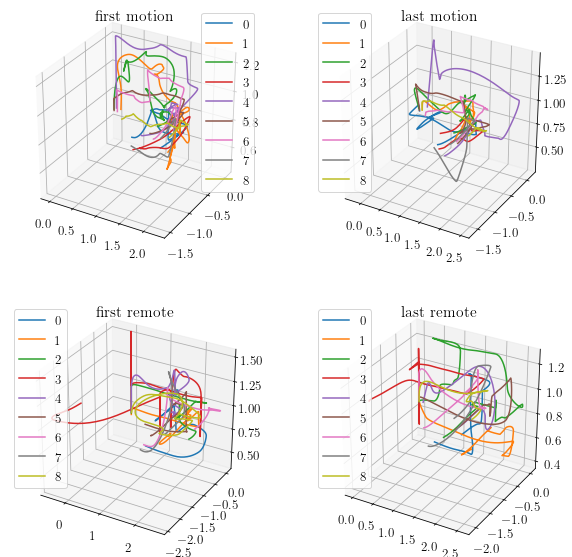

In [81]:
mpl.rcParams.update(params)

plt.figure(figsize = [10,10])

for idx,i in enumerate(fields):
    ax = plt.subplot(2, 2, 1+idx, projection='3d')
    for idx1,log in enumerate(logs[i]):
        ax.plot(log['dronePosition.x'],log['dronePosition.z'],log['dronePosition.y'], label = str(idx1))
#         print(len(log))
    plt.legend()
    plt.title(fields[idx])
#     define_plot_pos(ax)

# Time analysis

first motion
[21.800769805908203, 48.48721504211426, 42.701393127441406, 7.239009857177734, 28.73888111114502, 18.53849506378174, 28.513503074645996, 8.412460327148438, 20.788070678710938]
mean =  25.02442200978597
std =  13.130257121665654

last motion
[20.825546264648438, 23.739212036132812, 31.913726806640625, 11.189292907714844, 19.663116455078125, 19.25157928466797, 23.251205444335938, 12.13909912109375, 14.151191711425781]
mean =  19.569330003526474
std =  6.144606228397252

first remote
[19.75074577331543, 33.938032150268555, 21.687971115112305, 34.86320877075195, 20.2139310836792, 18.82541847229004, 13.762761116027832, 6.4022064208984375, 20.93840789794922]
mean =  21.153631422254776
std =  8.381371254729503

last remote
[18.051559448242188, 26.850936889648438, 48.163787841796875, 24.0020751953125, 8.026542663574219, 25.302108764648438, 16.689300537109375, 6.851325988769531, 11.501594543457031]
mean =  20.604359096950954
std =  11.945279641785593

first motion last motion
p = 0

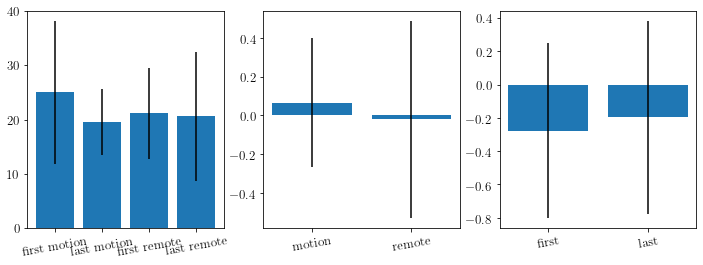

In [82]:
def compTime(df):
    return df['absoluteTime'].iloc[-1] - df['absoluteTime'].iloc[0]
time = runBasicAnalysis(compTime)
basic_plot(time)

# Distance Analysis

first motion
[3.6998659219411243, 5.122467314561557, 4.446784747331457, 3.020189954827304, 4.622371933422231, 3.309436295529979, 3.6606120363415626, 2.2268208774053653, 2.456850649607131]
mean =  3.6183777478853014
std =  0.925191940692519

last motion
[4.50755307496842, 3.300304543087247, 3.9772888394489176, 2.89003466660615, 5.601878394538185, 3.9784550842370288, 3.140038484310666, 2.8336577746125595, 2.9695115368328446]
mean =  3.6887469331824465
std =  0.871530549744812

first remote
[5.484564224548208, 5.612117103426632, 4.938139175869224, 12.136169806556396, 5.036048252877962, 4.018796001992879, 4.025733830162613, 3.189911520614153, 8.825376672600822]
mean =  5.918539620960988
std =  2.661828592664293

last remote
[3.6571899549481675, 5.630967140159299, 7.400991243304349, 6.850404950704354, 3.5240413154895696, 4.640549703233899, 4.95642454522431, 3.2406909683770087, 3.6604100608320778]
mean =  4.8401855424747815
std =  1.4282614405056546

first motion last motion
p = 0.9647839776

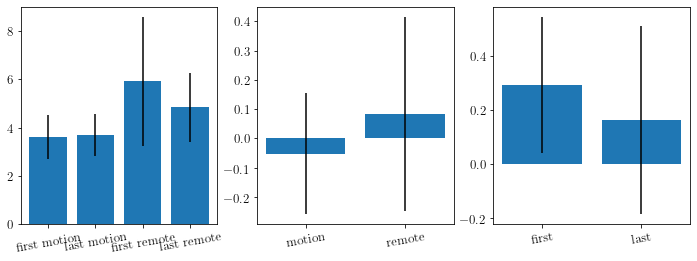

In [83]:
def compDist(df):
    
    steps = 10
    
    df['dronePositionFiltered.x'] = running_average(df['dronePosition.x'], steps)
    df['dronePositionFiltered.y'] = running_average(df['dronePosition.y'], steps)
    df['dronePositionFiltered.z'] = running_average(df['dronePosition.z'], steps)
    
    x = df['dronePositionFiltered.x'].values
    y = df['dronePositionFiltered.y'].values
    z = df['dronePositionFiltered.z'].values

    dx = np.diff(x)
    dy = np.diff(y)
    dz = np.diff(z)

    dd = np.sqrt(dx**2+dy**2+dz**2)
    d = np.sum(dd)

    return d

dist = runBasicAnalysis(compDist)
basic_plot(dist)

# Velocity Analysis

first motion
[0.15974863089858143, 0.10012234622156214, 0.09971723595464946, 0.34414099369739237, 0.15261026709366868, 0.18404415814291733, 0.13014025408293242, 0.18360943082556047, 0.1193419879248198]
mean =  0.16371947831578712
std =  0.07050422873688297

last motion
[0.22520659698809686, 0.13049380485444914, 0.12090049870536618, 0.24165216437443518, 0.26487038020133813, 0.21293180645033366, 0.13303902620710278, 0.17409614558428338, 0.2088780275567141]
mean =  0.1902298278802355
std =  0.049674507358665035

first remote
[0.23712431403449621, 0.1686852014502533, 0.22807379572223765, 0.3369353886614653, 0.2369458730211949, 0.1751517128894564, 0.2721726602344862, 0.37643876637396967, 0.41309462032293826]
mean =  0.2716247036344998
std =  0.08128049494011366

last remote
[0.16634485047544512, 0.21581536806463947, 0.15057645082686189, 0.2828857814220495, 0.4701949709406362, 0.18075809700861745, 0.2995987074358844, 0.3213372718564781, 0.28824668729661795]
mean =  0.2639731317030256
std =  

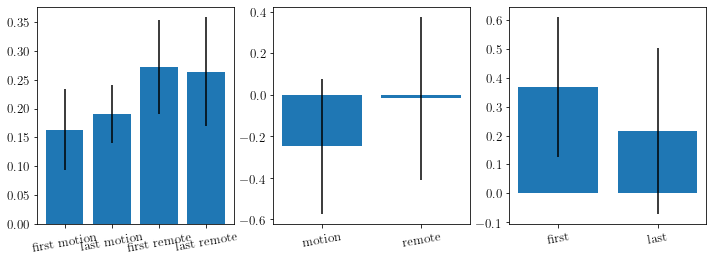

In [84]:
def compVel(df):
    x = df['dronePositionFiltered.x'].values
    y = df['dronePositionFiltered.y'].values
    z = df['dronePositionFiltered.z'].values
    t = df['absoluteTime'].values

    dx = np.diff(x)
    dy = np.diff(y)
    dz = np.diff(z)
    dt = np.diff(t)
    
    vx = np.append([0],dx/dt)
    vy = np.append([0],dy/dt)
    vz = np.append([0],dz/dt)
    
    df['droneVelocity.x'] = vx
    df['droneVelocity.y'] = vy
    df['droneVelocity.z'] = vz
    
    steps = 20    
    
    df['droneVelocityFiltered.x'] = running_average(df['droneVelocity.x'], steps)
    df['droneVelocityFiltered.y'] = running_average(df['droneVelocity.y'], steps)
    df['droneVelocityFiltered.z'] = running_average(df['droneVelocity.z'], steps)

    dv = np.sqrt(df['droneVelocityFiltered.x'][100:]**2+df['droneVelocityFiltered.y'][100:]**2+df['droneVelocityFiltered.z'][100:]**2)
    
    v = np.mean(dv)
    
    return v

vel = runBasicAnalysis(compVel)
basic_plot(vel)

# Acceleration Analysis

first motion
[0.27135989569593155, 0.15304382988093393, 0.13375379478407937, 0.31934280327777714, 0.24995374908930135, 0.2933036837143928, 0.2869608280256654, 0.3362861354808946, 0.2264020028828759]
mean =  0.25226741364798355
std =  0.06614424875885032

last motion
[0.3996120064789827, 0.14959110014779825, 0.1686126586537449, 0.20395891284183093, 0.44987165687843944, 0.37996590779930856, 0.30722330618172894, 0.33834778437401386, 0.3521812597496765]
mean =  0.3054849547895027
std =  0.10102960119027998

first remote
[0.3168511924372418, 0.21155770584375866, 0.25569155891007656, 0.42332688066391566, 0.33919096972982343, 0.2621157540318616, 0.33245928793147816, 0.6177520860867451, 0.5120624249354833]
mean =  0.36344531784115386
std =  0.12428131091312092

last remote
[0.17477562056894255, 0.2592936963310749, 0.16185523785128125, 0.3219964894876211, 0.6017352319099966, 0.17914278948492093, 0.3172166165701152, 0.46723054750757326, 0.37442569152823035]
mean =  0.3175191023599729
std =  0.13

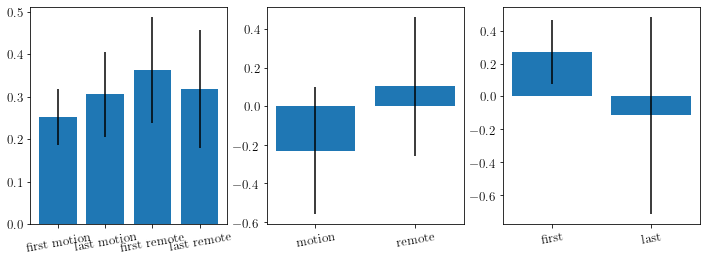

In [85]:
def compAcc(df):
    vx = df['droneVelocityFiltered.x'].values
    vy = df['droneVelocityFiltered.y'].values
    vz = df['droneVelocityFiltered.z'].values
    t = df['absoluteTime'].values
    
    dvx = np.diff(vx)
    dvy = np.diff(vy)
    dvz = np.diff(vz)
    dt = np.diff(t)
    
    ax = np.append([0],dvx/dt)
    ay = np.append([0],dvy/dt)
    az = np.append([0],dvz/dt)
    
    df['droneAcceleration.x'] = ax
    df['droneAcceleration.y'] = ay
    df['droneAcceleration.z'] = az
    
    steps = 30    
    
    df['droneAccelerationFiltered.x'] = running_average(df['droneAcceleration.x'], steps)
    df['droneAccelerationFiltered.y'] = running_average(df['droneAcceleration.y'], steps)
    df['droneAccelerationFiltered.z'] = running_average(df['droneAcceleration.z'], steps)

    da = np.sqrt(df['droneAccelerationFiltered.x'][100:]**2+df['droneAccelerationFiltered.y'][100:]**2+df['droneAccelerationFiltered.z'][100:]**2)
    
    a = np.mean(da)

    return a

acc = runBasicAnalysis(compAcc)
basic_plot(acc)

# Jerk Analysis

first motion
[0.751712807035231, 0.3819883179686926, 0.3022204790235721, 0.46846824909865087, 0.6568483250051232, 0.8900480712232762, 0.9561568654444541, 1.0286379904984946, 0.7886710601021013]
mean =  0.691639129488844
std =  0.24369246734028996

last motion
[0.9651564011866695, 0.39890030229370327, 0.3944519151055516, 0.4363301901225379, 1.1489301977509867, 1.0955900335498847, 1.034064369583803, 0.9259757839435275, 1.250531253683727]
mean =  0.8499922719133769
std =  0.32406270440946294

first remote
[0.6282898041741976, 0.46722603069881324, 0.5885461846052017, 0.8619084985087617, 0.7689544440149907, 0.5365366753722961, 0.6692102033292678, 1.2980454078088572, 1.0696804053677553]
mean =  0.7653775170977934
std =  0.2552208863555662

last remote
[0.32824958659055287, 0.5489461851139479, 0.379994167731079, 0.7492139548325932, 1.4893083662844824, 0.32578870432435325, 0.6949398625625789, 0.784309468875626, 0.9236906709906331]
mean =  0.6916045519228718
std =  0.34727830941024046

first mo

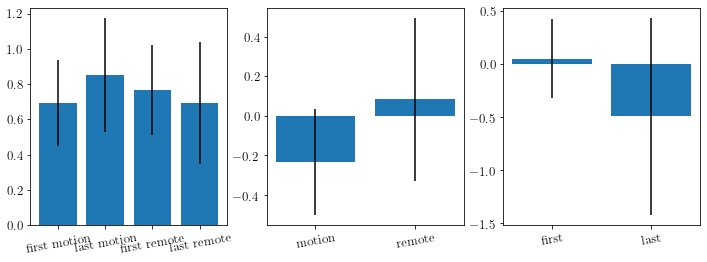

In [86]:
def compJerk(df):
    ax = df['droneAccelerationFiltered.x'].values
    ay = df['droneAccelerationFiltered.y'].values
    az = df['droneAccelerationFiltered.z'].values
    t = df['absoluteTime'].values
    
    dax = np.diff(ax)
    day = np.diff(ay)
    daz = np.diff(az)
    dt = np.diff(t)
    
    jx = np.append([0],dax/dt)
    jy = np.append([0],day/dt)
    jz = np.append([0],daz/dt)
    
    df['droneJerk.x'] = jx
    df['droneJerk.y'] = jy
    df['droneJerk.z'] = jz
    
    steps = 40    
    
    df['droneJerkFiltered.x'] = running_average(df['droneJerk.x'], steps)
    df['droneJerkFiltered.y'] = running_average(df['droneJerk.y'], steps)
    df['droneJerkFiltered.z'] = running_average(df['droneJerk.z'], steps)

    dj = np.sqrt(df['droneJerkFiltered.x'][100:]**2+df['droneJerkFiltered.y'][100:]**2+df['droneJerkFiltered.z'][100:]**2)
    
    
    j = np.mean(dj)

    return j

jerk = runBasicAnalysis(compJerk)
basic_plot(jerk)

# Energy Analysis

first motion
[309.20947685720927, 405.1817514638891, 342.04310919953224, 220.14053073980602, 365.5878566401576, 288.9812959400664, 321.85310264611485, 132.87360020532182, 226.03989463100342]
mean =  290.21229092478893
std =  79.39566703388887

last motion
[415.055053694497, 260.3375732557752, 306.7728907857787, 218.30294383172426, 399.39446261181456, 355.51470338310196, 267.17665682986564, 176.81617209273261, 263.61070405821454]
mean =  295.88679561594495
std =  75.95008457518055

first remote
[414.26306482416015, 454.33390547368015, 371.4893638136557, 628.6676263077, 381.56027857962397, 278.0929755869314, 291.1963215040025, 230.71407636540857, 752.9181880547565]
mean =  422.58175561221316
std =  160.525693548354

last remote
[222.53911222084116, 453.91563874563104, 562.157934179197, 445.11840914068716, 271.1302840882006, 349.5066033793515, 385.5007062640492, 208.69622541754512, 316.51397335740046]
mean =  357.23098742143367
std =  110.15226856757106

first motion last motion
p = 0.894

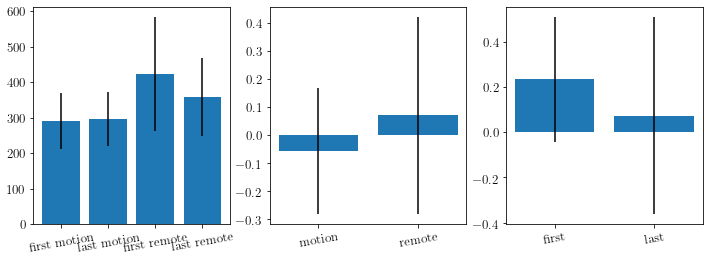

In [87]:
def compEnergy(df):
    df['controlInput'] = np.sqrt(df['controlSpeed.x']**2+df['controlSpeed.y']**2+df['controlSpeed.z']**2)
    return df['controlInput'].sum()

energy = runBasicAnalysis(compEnergy)
basic_plot(energy)

# Power Analysis

first motion
[27.33441781574532, 19.83638736336342, 8.266059588506856, 4.230392598985738, 21.784058164421047, 19.920046143399222, 36.65067386349562, 10.246117915640554, 27.807916997271235]
mean =  19.56400782786989
std =  9.860197801709552

last motion
[34.919643917257204, 14.014263004475279, 8.382662771186704, 4.015868349012127, 19.59623552549739, 23.770866683057044, 33.343516390366815, 12.352434202828325, 25.97648894545521]
mean =  19.596886643237344
std =  10.18742624352463

first remote
[10.96415972855248, 15.227143711523905, 9.587057007009987, 15.35110741336701, 12.327617264967262, 8.123690323292276, 8.85387359515694, 5.778787432480447, 14.598573871359378]
mean =  11.201334483078854
std =  3.2194915062151175

last remote
[6.002674169850743, 13.974775279907258, 16.270101594637417, 12.859384013925418, 7.31674472522072, 8.71790075249546, 10.598255131156685, 4.686560162697667, 7.711330707441262]
mean =  9.793080726370292
std =  3.6750594791782736

first motion last motion
p = 0.894625

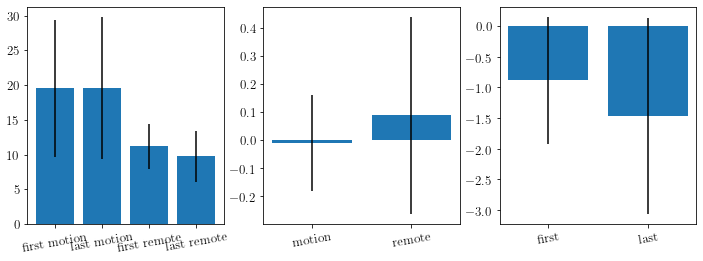

In [88]:
def compDEnergy(df):
    dEnergy = np.abs(np.diff(df['controlInput']))
    return np.sum(dEnergy)

dEnergy = runBasicAnalysis(compDEnergy)
basic_plot(dEnergy)

# Collision Analysis

In [89]:
coll_df = pd.read_csv('/Volumes/GoogleDrive/My Drive/Matteo/EPFL/LIS/PhD/Bidirectional_wearable_interface/DATA/Haptics/Bidir - haptics ZY collisions - Sheet1.csv')

In [90]:
coll = {}

coll['motion'] = coll_df[coll_df['Interface']=='Motion']
coll['remote'] = coll_df[coll_df['Interface']=='Remote']


coll['first motion'] = coll['motion'][coll['motion']['Run']==1]
coll['last motion'] = coll['motion'][coll['motion']['Run']==5]
coll['first remote'] = coll['remote'][coll['remote']['Run']==1]
coll['last remote'] = coll['remote'][coll['remote']['Run']==5]



consider all runs

mean motion =  1.0
std motion =  0.9428090415820634
mean remote =  3.4444444444444446
std remote =  1.0657403385139377

total motion =  9.0
total remote =  31.0

p = 0.0012411134893360086 !!!!!!!!!!

consider first runs

mean motion =  0.2222222222222222
std motion =  0.41573970964154905
mean remote =  0.7777777777777778
std remote =  0.41573970964154905

total motion =  2.0
total remote =  7.0

p = 0.021985734811330877 !!!!!!

consider last runs

mean motion =  0.0
std motion =  0.0
mean remote =  0.5555555555555556
std remote =  0.4969039949999533

total motion =  0.0
total remote =  5.0

p = 0.010556660425736162 !!!!!!


Text(0.5, 1.0, 'Collisions - last run')

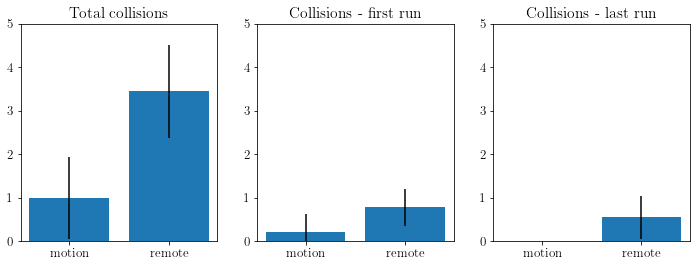

In [91]:
def compute_mean_std_collisions(data_m, data_r):
    
    coll_per_sub_m = []
    
    for sub in np.unique(data_m['Subject']):
        sub_coll = data_m[data_m['Subject']==sub]
        
        coll_per_sub_m.append(sub_coll['Collided Z'].sum())
        
    coll_per_sub_r = []
    
    for sub in np.unique(data_r['Subject']):
        sub_coll = data_r[data_r['Subject']==sub]
        
        coll_per_sub_r.append(sub_coll['Collided Z'].sum())
    
    mean_m = np.mean(coll_per_sub_m)
    std_m = np.std(coll_per_sub_m)
    mean_r = np.mean(coll_per_sub_r)
    std_r = np.std(coll_per_sub_r)

    print('mean motion = ', mean_m)
    print('std motion = ', std_m)
    print('mean remote = ', mean_r)
    print('std remote = ', std_r)
    print('')
    print('total motion = ', np.sum(coll_per_sub_m))
    print('total remote = ', np.sum(coll_per_sub_r))
    print('')

    t, p = t_test_kruskal(coll_per_sub_m, coll_per_sub_r)

    print_p(p)
    
    return [coll_per_sub_m, coll_per_sub_r]

print('')
print('consider all runs')
print('')
all_m, all_r = compute_mean_std_collisions(coll['motion'], coll['remote'])
    
print('')
print('consider first runs')
print('')
first_m, first_r = compute_mean_std_collisions(coll['first motion'], coll['first remote'])
    
print('')
print('consider last runs')
print('')
last_m, last_r = compute_mean_std_collisions(coll['last motion'], coll['last remote'])


    
fig = plt.figure(figsize=(12, 4))
ax = fig.add_subplot(131)
ax.bar([0, 1],
   [np.mean(all_m), np.mean(all_r)],
      yerr = [np.std(all_m), np.std(all_r)])

plt.xticks(range(2), ['motion', 'remote'])
plt.ylim([0, 5])
plt.title('Total collisions')

ax = fig.add_subplot(132)
ax.bar([0, 1],
   [np.mean(first_m), np.mean(first_r)],
      yerr = [np.std(first_m), np.std(first_r)])

plt.xticks(range(2), ['motion', 'remote'])
plt.ylim([0, 5])
plt.title('Collisions - first run')

ax = fig.add_subplot(133)
ax.bar([0, 1],
   [np.mean(last_m), np.mean(last_r)],
      yerr = [np.std(last_m), np.std(last_r)])

plt.xticks(range(2), ['motion', 'remote'])
plt.ylim([0, 5])
plt.title('Total collisions')
plt.title('Collisions - last run')

# Go-through passing Analysis

In [107]:
def comp_max_dist(df):
    
    dist_obstacle = -1
    collider = 0.12

    z_cross = dist_obstacle + collider
    
    z = df['dronePosition.z']
    
    
#     print()
    for idx,i in enumerate(z):
        if idx>0:
            if z[idx-1]>z_cross and z[idx]<z_cross:
#                 print(idx)
                break
                
    
    return [df['dronePosition.x'][idx], df['dronePosition.y'][idx]]

cross_ret = runHapticsZAnalysis(comp_max_dist)

motion
[2.20554518699646, 2.0448811054229736, 2.1115200519561768, 1.6321910619735718, 1.9299910068511963, 2.025785207748413, 2.1492810249328613, 1.4885929822921753, 1.9889394044876099, 1.8935139179229736, 1.8988595008850098, 2.0341591835021973, 1.9541471004486084, 2.024033546447754, 2.016711950302124, 2.088818311691284, 2.280486822128296, 1.9913796186447144, 2.2584779262542725, 1.9066413640975952, 1.9657769203186035, 1.892768144607544, 1.8573359251022339, 1.8663878440856934, 1.9408904314041138, 1.9328663349151611, 2.1458730697631836, 2.08294939994812, 1.904898762702942, 1.9648393392562866, 1.9086508750915527, 2.1009740829467773, 2.0287551879882812, 2.1453092098236084, 1.965834379196167, 1.9557901620864868, 1.9807027578353882, 1.9023194313049316, 2.051631450653076, 1.9435522556304932, 2.0466153621673584, 2.0209507942199707, 1.985171914100647, 2.136683464050293, 2.091541290283203]
[0.9548597931861877, 1.0137970447540283, 0.9962010979652405, 0.9877849221229553, 0.9852827787399292, 0.95537

In [109]:
coord = ['X', 'Y']
cross = {}
x_center = 2
y_center = 1

cross_dic = {'X':cross_ret[0], 'Y':cross_ret[1]}
center = {'X':2, 'Y':1}

for c in coord:
    cross[c] = {}
    for i in interfaces:
        cross[c][i] = np.array(cross_dic[c][i]) - center[c]

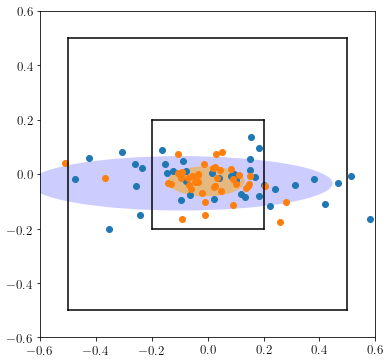

In [126]:
fig = plt.figure()
ax = fig.add_subplot(111)

ax.scatter(cross['X']['remote'], cross['Y']['remote'])
ax.scatter(cross['X']['motion'], cross['Y']['motion'])

l = 0.2
ax.plot([-l, -l], [-l, l] ,'k')
ax.plot([l, l], [-l, l] ,'k')
ax.plot([-l, l], [-l, -l] ,'k')
ax.plot([-l, l], [l, l] ,'k')
l = 0.5
ax.plot([-l, -l], [-l, l] ,'k')
ax.plot([l, l], [-l, l] ,'k')
ax.plot([-l, l], [-l, -l] ,'k')
ax.plot([-l, l], [l, l] ,'k')

plt.xlim([-0.6, 0.6])
plt.ylim([-0.6, 0.6])



ellipse = Ellipse((np.mean(cross['X']['remote']), np.mean(cross['Y']['remote'])), width=np.std(cross['X']['remote'])*2,
        height=np.std(cross['Y']['remote'])*2,
        alpha=0.2,
        facecolor='blue', zorder=-2)
ax.add_patch(ellipse)


ellipse = Ellipse((np.mean(cross['X']['motion']), np.mean(cross['Y']['motion'])), width=np.std(cross['X']['motion'])*2,
        height=np.std(cross['Y']['motion'])*2,
        alpha=0.5,
        facecolor='orange', zorder=-1)
ax.add_patch(ellipse)

-0.09602731830543942
0.5430182594159135
-0.0057105541229248045
0.1377972457505892
p = 0.0003861121183385026 !!!!!!!!!!
-0.033510043885972764
0.1000803082686253
-0.026077542040083144
0.05544977345280566
p = 0.06494240250006876 !


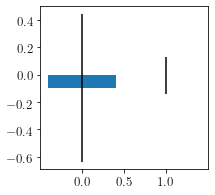

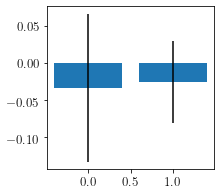

In [128]:
for c in coord:

    print(np.mean(cross[c]['remote']))
    print(np.std(cross[c]['remote']))
    print(np.mean(cross[c]['motion']))
    print(np.std(cross[c]['motion']))

    fig = plt.figure(figsize=[3,3])
    ax = fig.add_subplot(111)

    ax.bar([0,1], 
            [np.mean(cross[c]['remote']), np.mean(cross[c]['motion'])],
          yerr = [np.std(cross[c]['remote']), np.std(cross[c]['motion'])])

    print_p(t_test_levene(cross[c]['remote'], cross[c]['motion'])[1])

# TEST